# <center> Quantum Walks </center>

#### Submission by: Haemanth Velmurugan

### Task:
Implement a quantum walk operator for the case of a line graph with 16 nodes as hown below
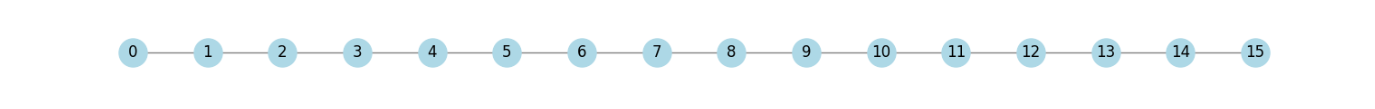

### Random Walks:

A 1-dimensional random walk would basically choose randomly whether to move one step to the left or right, and make this decision at every step to eventually reach a destination point or traverse the graph. An example has been shown below [[source]](https://www.mit.edu/~kardar/teaching/projects/chemotaxis(AndreaSchmidt)/random.htm)

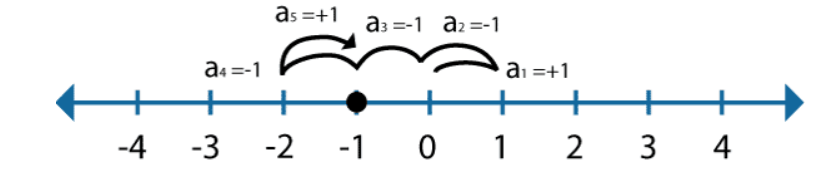

Such a walk can also be performed on any given graph $G=(V,E)$ and at any point in time, we use the edge information of the current vertex to randomly move to another vertex in the graph. 

### Quantum Walks:
A straight-forward approach would be start with a superposition of all vertices in the graph and apply a Unitary $U$ such that it prepares an equal superposition of all the neighbours of a given vertex $j$ in $G$ <br>

  <center>$U|j\rangle=\frac{1}{\sqrt{deg(j)}}\underset{k:(j,k)\in E}{\sum}|k\rangle$</center> 

However $U$ when applied to orthogonal states $|j\rangle, |k\rangle$ corresponding to adjacent vertices $j, k$ that are connected to a common vertex $l$, will then give rise to non-orthogonal states (since $U$ on $|j\rangle$ and $|k\rangle$ will yield a component across $|l\rangle$ for both). To tackle this issue, we resort to enlarging the Hilbert space, our exploration space, by constructing the space on pairs of vertices $(j,k)$. The quantum states are then of the form $|j,k\rangle$ denoting a random walk that starts at vertex $j$ and moves towards $k$.

Each step of the walk is then composed of two operators:

* An operator $W$ to model the possible choices we have at any given step <br>
  <center> $W = \underset{j \in V}{\sum}|j\rangle\langle j|\otimes U_j(2|0\rangle\langle0|-1)U_j^{\dagger}$ </center>
  <center> where $U_j|0\rangle = U|j\rangle$ as described above </center>

* Operator $S$ to move to the choices we have produced using $W$. <br>
  To maintain the operations unitary, we simply swap the current vertex register with the second register containing the choices (our choices become the current vertex we are at for the next time step)
  The operator is given as <center>$S=\underset{(j,k)\in E}{\sum}|j,k\rangle\langle k,j|$</center>

One step of the quantum walk is then described by the combined operator $SW$

### Quantum Walks (Task Solution) in Classiq

#### Import Classiq

In [1]:
from classiq import *

Since there are $16$ nodes in the graph, we require $\log_2{16} = 4$ qubits to store all the vertices

In [2]:
size = 4

#### W operator:

In order to implement $W = \underset{j \in V}{\sum}|j\rangle\langle j|\otimes U_j(2|0\rangle\langle0|-1)U_j^{\dagger}$, we show how to approach each of its components as follows: 

* $2|0\rangle\langle0|-1$ <br>
  Consider the effect of applying this operator on the $|0\rangle$ and $|1\rangle$ states <br>
  <center> $(2|0\rangle\langle0|-1)|0\rangle = 2|0\rangle\langle0|0\rangle - |0\rangle = 2|0\rangle - |0\rangle = |0\rangle$ </center>
  <center> $(2|0\rangle\langle0|-1)|1\rangle = 2|0\rangle\langle0|1\rangle - |0\rangle = 0 - |1\rangle = -|1\rangle$ </center> <br>
  
  Essentially, this operator flips the phase of $|1\rangle$ state and left the $|0\rangle$ state unaffected.
  In fact, this would hold true for any state $|\psi\rangle$ orthogonal to $|0\rangle$ as $\langle0|\psi\rangle=0$ and hence <br>
  <center> $(2|0\rangle\langle0|-1)|\psi\rangle = 2|0\rangle\langle0|\psi\rangle - |\psi\rangle = 0-|\psi\rangle = -|\psi\rangle$ </center>

  Thus for any basis state $|j\neq0\rangle$ we have <center> $(2|0\rangle\langle0|-1)|j\neq0\rangle = -|j\neq0\rangle$ </center>

  In order to implement this operator, we just have to flip the phase of states $|j\neq0\rangle$, which can be easily done through **phase-kickback**

* Phase Kickback in Classiq <br>
    Consider the 1-qubit superposition state $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. If we use an auxiliary qubit in $|-\rangle = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ state and apply XOR on the auxiliary qubit and the result of the comparison (data qubit $\neq 0$), we get <br>
    <center> $\frac{1}{2}(|0\rangle(|0\oplus0\rangle -|1\oplus0\rangle) +|1\rangle(|0\oplus1\rangle - |1\oplus1\rangle))$</center>
    <center> $\frac{1}{2}(|0\rangle(|0\rangle-|1\rangle) + |1\rangle(|1\rangle - |0\rangle))$</center>
    <center> $\frac{1}{2}(|0\rangle(|0\rangle-|1\rangle) - |1\rangle(|0\rangle - |1\rangle))$</center>
    <center> $\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)|-\rangle$</center>

    Thus we see that the phase of state $|1\rangle$ has been flipped. For more details refer to Classiq's tutorial [here](https://docs.classiq.io/latest/explore/tutorials/phase_kickback/phase_kickback/) 

* $U_j$ <br>
  Given vertex state $|j\rangle$ we need to prepare a superposition of all its neighbours. For the case of the line graph, we see that every vertex $j$ is connected to the vertex immediately before it $j-1$ and immediately after it $j+1$ except the first ($0$) and last vertices ($15$ in our example). Using this knowledge we can use Classiq's prepare_state functions to prepare the states corresponding to each vertex $j$

  To apply $U_j(2|0\rangle\langle 0|-1)U_j^\dagger$, we use the **within_apply** construct offered by Classiq.

Thus to implement $W$, we apply $U_j(2|0\rangle\langle 0|-1)U_j^\dagger$ controlled by the vertex state $|j\rangle$

In [3]:
@qfunc
def prepare_minus(x: QBit):
  '''
  Helper function to prepare ancilla in |-> state to apply phase kickback
  '''
  X(x)
  H(x)

In [4]:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)  # flip the phase when state ≠ 0

In [5]:
@qfunc
def zero_diffuzer(x: QNum):
  # oracle implementing phase kickback
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux), 
              action=lambda: diffuzer_oracle)

In [6]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    
    # prepare the superposition of all neighbour nodes of vertex i
    prob = [0 for j in range(2**size)]
    if i==0:  
        # node 0 is connected only to node 1
        prob[i+1] = 1.0
    elif i == 2**size-1:
        # node 15 (or last node) is connected only to its previous node, 14 here
        prob[i-1] = 1.0
    else: 
        # every other intermediate node i is connected to both node i-1 and node i+1
        prob[i-1] = 0.5
        prob[i+1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


In [7]:
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

#### S operator

The S operator is responsible for updating our current vertex $j$ with the neighbouring vertices $k$ that are adjaccent to $j$. In order to do this, $S$ swaps $j$ and $k$ if $(j,k) \in E$ (if the edge exists in $G$) 

To know if a given vertex $k$ is adjacent to $j$, we prepare an edge oracle. From the line graph structure we have, it is obvious that $k$ is adjacent to $j$ only if $k=j-1$ or $k=j+1$. This oracle sets an auxiliary qubit $res$, indicating whether $(j,k)$ form an edge ($res$ set to $|1\rangle$) or not ($res$ set to $|0\rangle$).

Whenever $res$ is state $|1\rangle$, we swap the vertices ($|j\rangle$) and it neighbours ($|k\rangle$). This can be achieved using the **bitwise_swap** operation controlled by the condition $res==1$

In [8]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= ((adjacent_vertices == vertices - 1) | (adjacent_vertices == vertices + 1))  # set res to 1 when two vertices are adjacent

In [9]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

In [10]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

#### Puting everything together

In [11]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)  # prepare a superposition of all vertices in G
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

In [12]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

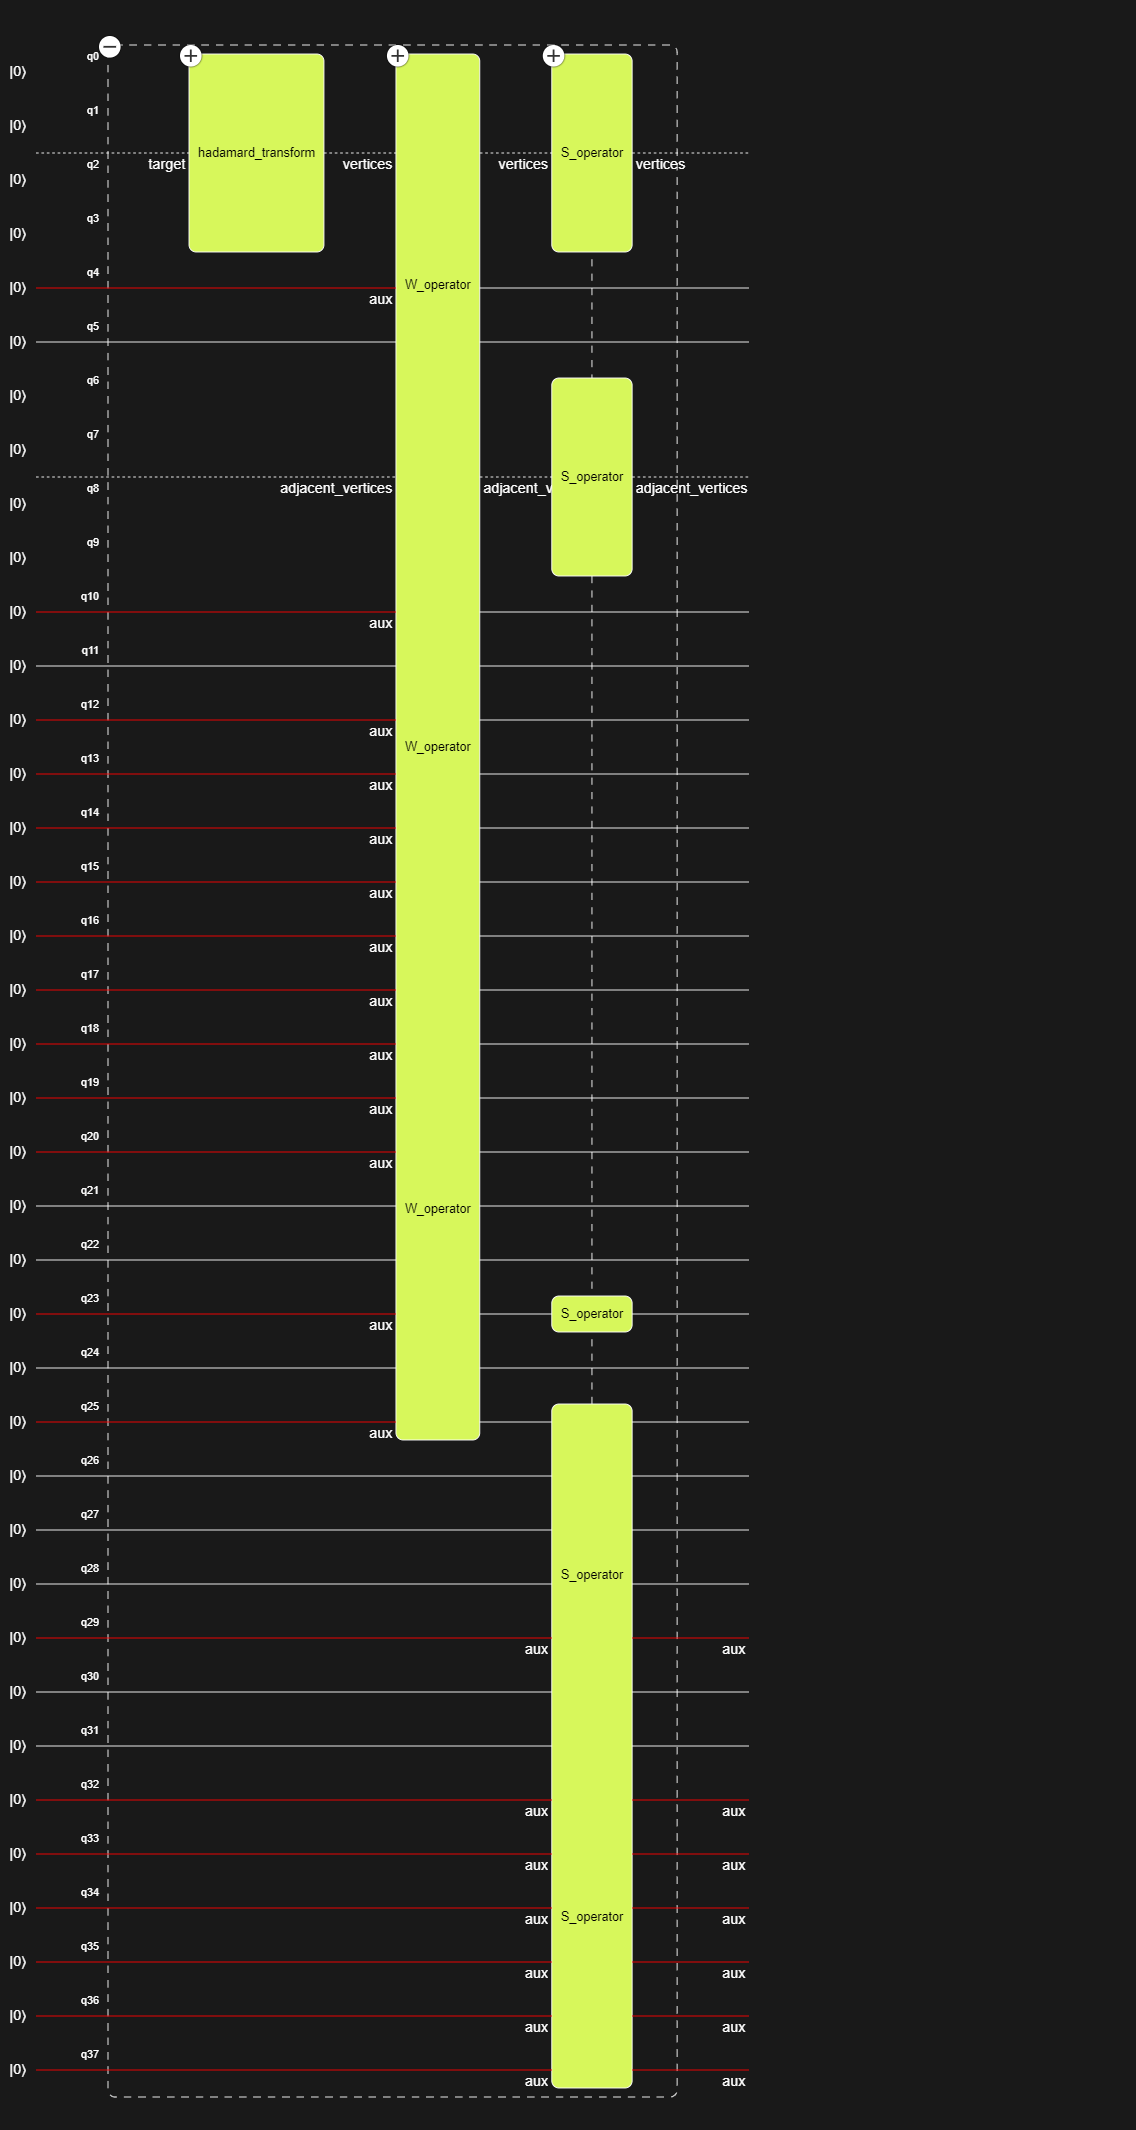